In [4]:
import scanpy as sc
import os
import anndata
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from scanpy.metrics.specificity.plot import marker_genes_distribution, one_v_max_genelist
import numpy as np
from scanpy.metrics.specificity.get_data import get_average_celltype_counts,get_spe
from scanpy.metrics.specificity.compute import one_v_max_matrix
from joblib import dump, load
import pickle
import seaborn as sns
import copy
import upsetplot
os.chdir('C:\\Users\\ipmc\\Documents\\Metrics_results')

## Load data

In [5]:
DATA_PATH = r'data/'
MODEL_PATH = r'models/'

In [6]:
barbry_file = 'HCA_Barbry_Grch38_Raw_filter_Norm.h5ad'
meyer_file = 'lung.cellxgene.h5ad'

In [7]:
barbry = anndata.read_h5ad(DATA_PATH + 'HCA_Barbry_Grch38_Raw_filter_Norm.h5ad')
meyer = anndata.read_h5ad(DATA_PATH + 'lung.cellxgene.h5ad')

C:\Users\ipmc\.conda\envs\scanpypip\lib\site-packages\anndata\compat\__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
C:\Users\ipmc\.conda\envs\scanpypip\lib\site-packages\anndata\compat\__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [8]:
a=np.array(barbry.X.todense()[:,0])


In [9]:
sc.pp.highly_variable_genes(barbry)

In [10]:
barbry.var

,gene_ids,feature_types,genome,n_counts,highly_variable,means,dispersions,dispersions_norm
AL669831.5,ENSG00000237491,Gene Expression,ucagenomix-cellranger-GRCh38-3.0.0,3004.0,False,0.061341,1.173543,-0.641477
LINC00115,ENSG00000225880,Gene Expression,ucagenomix-cellranger-GRCh38-3.0.0,964.0,False,0.027584,1.389954,-0.191512
FAM41C,ENSG00000230368,Gene Expression,ucagenomix-cellranger-GRCh38-3.0.0,6935.0,False,0.197905,1.660163,0.370307
NOC2L,ENSG00000188976,Gene Expression,ucagenomix-cellranger-GRCh38-3.0.0,16862.0,False,0.339094,1.345867,-0.283180
PLEKHN1,ENSG00000187583,Gene Expression,ucagenomix-cellranger-GRCh38-3.0.0,1767.0,False,0.033787,1.164980,-0.659280
...,...,...,...,...,...,...,...,...
AC007325.4,ENSG00000278817,Gene Expression,ucagenomix-cellranger-GRCh38-3.0.0,5882.0,False,0.128567,1.306934,-0.364129
AC007325.2,ENSG00000277196,Gene Expression,ucagenomix-cellranger-GRCh38-3.0.0,765.0,False,0.023429,1.424258,-0.120188
AL354822.1,ENSG00000278384,Gene Expression,ucagenomix-cellranger-GRCh38-3.0.0,795.0,False,0.017429,1.275135,-0.430245
AC004556.1,ENSG00000276345,Gene Expression,ucagenomix-cellranger-GRCh38-3.0.0,3645.0,False,0.101551,1.655506,0.360624


In [11]:
barbry.X.todense().mean(axis=0)

matrix([[0.03265522, 0.01286653, 0.09192908, ..., 0.00902156, 0.04433792,
         0.03552148]])

## Détermination des gènes marqueurs selon plusieurs méthodes

On va tester la plupart des méthodes de ranking_genes_group.
Pour ce qui est de la spécificité, on peut en faire plusieurs cat. Dans un premier temps, on garde les high et les unique et on regarde ce que ça donne (combien yen a etc...). On pourra ensuite jeter un coup d'oeil aux multi spé mais yaura surement besoin de la métrique magique.

In [12]:
sc.tl.rank_genes_groups(barbry, 'CellType', method='t-test')
#sc.pl.rank_genes_groups(barbry, n_genes=20, sharey=False)

ttest_de =  copy.deepcopy(barbry.uns['rank_genes_groups'])

C:\Users\ipmc\.conda\envs\scanpypip\lib\site-packages\anndata\_core\anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


In [13]:
sc.tl.rank_genes_groups(barbry, 'CellType', method='wilcoxon')
#sc.pl.rank_genes_groups(barbry, n_genes=20, sharey=False)

wilco_de = copy.deepcopy(barbry.uns['rank_genes_groups'])

In [14]:
#sc.tl.rank_genes_groups(barbry, 'CellType', method='logreg')
#sc.pl.rank_genes_groups(barbry, n_genes=20, sharey=False)

#logreg_de = copy.deepcopy(barbry.uns['rank_genes_groups'])

In [15]:
barbry.uns['rank_genes_groups']['names'].dtype

dtype((numpy.record, [('AT1', 'O'), ('AT2', 'O'), ('B cells', 'O'), ('Basal', 'O'), ('Brush cells', 'O'), ('Cycling Basal', 'O'), ('Dendritic', 'O'), ('Deuterosomal', 'O'), ('Endothelial', 'O'), ('Fibroblast', 'O'), ('Ionocyte', 'O'), ('LT/NK', 'O'), ('Macrophage', 'O'), ('Mast cells', 'O'), ('Monocyte', 'O'), ('Multiciliated', 'O'), ('Multiciliated N', 'O'), ('PNEC', 'O'), ('Pericyte', 'O'), ('Plasma cells', 'O'), ('Precursor', 'O'), ('SMG Goblet', 'O'), ('Secretory', 'O'), ('Secretory N', 'O'), ('Serous', 'O'), ('Smooth muscle', 'O'), ('Suprabasal', 'O'), ('Suprabasal N', 'O')]))

In [16]:
def dict_to_df(DE_dico, n_genes):
    celltypes = barbry.obs['CellType'].cat.categories
    df = pd.DataFrame(index = np.linspace(1,n_genes,n_genes)  , columns = celltypes )
    for celltype in celltypes:
        df[celltype] = DE_dico['names'][celltype][0:n_genes]
    return df

In [17]:
wilco30 = dict_to_df(wilco_de,30)
ttest30 = dict_to_df(ttest_de,30)

In [18]:
wilco30_dict = wilco30.to_dict(orient='lines')
ttest30_dict = ttest30.to_dict(orient='lines')

C:\Users\ipmc\.conda\envs\scanpypip\lib\site-packages\pandas\core\frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


# Load specificity

This should now be included to scanpy

In [19]:
def find_max_celltype(gene,adata,partition_key="CellType"):
    get_average_celltype_counts(adata , partition_key = partition_key)
    gene_index = int(np.where(adata.var.index == gene)[0])
    max_celltype_index = np.argmax(adata.varm['ave_celltype_counts_' + partition_key][gene_index,:])
    max_celltype = list(adata.obs[partition_key].cat.categories)[max_celltype_index]
    return(max_celltype)

def full_spe_matrix(adata, partition_key: str = 'CellType') :
    shannon = get_spe(adata, spe_metric='shannon', partition_key=partition_key)
    tau = get_spe(adata, spe_metric='tau', partition_key=partition_key)
    gini = get_spe(adata, spe_metric='gini', partition_key=partition_key)
    one_v_max = one_v_max_matrix(adata,partition_key=partition_key)
    spe_matrix = pd.DataFrame(columns=['gene',
                                       'most expressed celltype',
                                       'one_v_max',
                                       'shannon',
                                       'tau',
                                       'gini'])
    for gene in adata.var.index :
        spe_matrix.loc[gene,:] = [gene,
                                  find_max_celltype(gene,adata,partition_key=partition_key),
                                  max(one_v_max[gene]), 
                                  shannon[gene],
                                  tau[gene],
                                  gini[gene]]
    return spe_matrix

In [20]:
spe_matrix = full_spe_matrix(barbry, partition_key='CellType')
clf_Deprez_366obs = load(MODEL_PATH + 'clf_train_Deprez_366obs.joblib')
spe_type = clf_Deprez_366obs.predict(spe_matrix[['one_v_max','shannon','tau','gini']])
spec_dict={'0':'equirep','1':'low','2':'multi-spec','3':'high','4':'unique'}
spe_matrix['spe_type'] = pd.Series(spe_type, index = spe_matrix.index).apply(str).replace(spec_dict)

C:\Users\ipmc\.conda\envs\scanpypip\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [21]:
barbry.varm['ave_celltype_counts_CellType'].shape

(14349, 28)

In [22]:
spe_matrix

,gene,most expressed celltype,one_v_max,shannon,tau,gini,spe_type
AL669831.5,AL669831.5,AT2,1.56192,0.637306,0.742319,0.391246,low
LINC00115,LINC00115,PNEC,1.22682,0.628045,0.626468,0.399453,equirep
FAM41C,FAM41C,Deuterosomal,1.12528,0.637185,0.663437,0.393725,equirep
NOC2L,NOC2L,Precursor,1.46304,0.673486,0.569871,0.219136,equirep
PLEKHN1,PLEKHN1,Suprabasal N,1.83215,0.519458,0.867355,0.66531,low
...,...,...,...,...,...,...,...
AC007325.4,AC007325.4,Deuterosomal,3.16325,0.538201,0.907686,0.615957,high
AC007325.2,AC007325.2,Cycling Basal,1.07778,0.414222,0.886558,0.792062,multi-spec
AL354822.1,AL354822.1,Ionocyte,1.26802,0.604515,0.729433,0.467284,equirep
AC004556.1,AC004556.1,Precursor,1.42064,0.578837,0.840537,0.550767,multi-spec


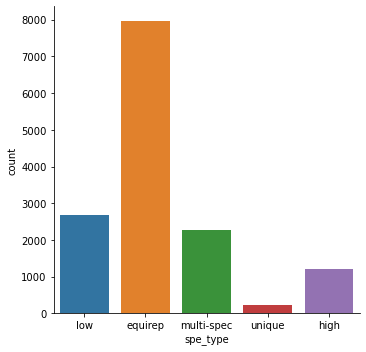

In [23]:
sns.catplot(x='spe_type',kind='count',data=spe_matrix)

### Get specificity markers - Direct Method

Select unique & high to get started

In [24]:
spe_genes = spe_matrix.loc[spe_matrix['spe_type'].isin(['unique','high']),:]
spe_genes = spe_genes[['gene','most expressed celltype']]

In [25]:
spe_genes 

,gene,most expressed celltype
MXRA8,MXRA8,Fibroblast
AL691432.2,AL691432.2,PNEC
PRKCZ,PRKCZ,AT1
DFFB,DFFB,AT1
PLEKHG5,PLEKHG5,PNEC
...,...,...
COL6A1,COL6A1,Fibroblast
COL6A2,COL6A2,Fibroblast
S100B,S100B,Serous
AC011043.1,AC011043.1,PNEC


In [29]:
spec_gene_groups = spe_genes.groupby('most expressed celltype')

In [30]:
n_genes_spec = {k: len(table.index) for k, table in spec_gene_groups}

In [31]:
group_size = pd.DataFrame(barbry.obs.groupby('CellType').size(),columns = ['group_size'])

In [32]:
len(n_genes_spec.keys())

27

In [ ]:
to_plot=group_size.join(n_genes_spec).sort_values('group_size')
sns.catplot(x='gene',y='group_size',data=to_plot,s=15,height=11,aspect=1)
plt.yscale('log')

In [38]:
spec_dict = {k: list(table.index) for k, table in spec_gene_groups}

In [ ]:
spec_dict

In [ ]:
sns.catplot(n_genes_spec,group_size)

# Upset Plots

In [ ]:
spec_dict
ttest30
wilco30

In [ ]:
def celltype_to_plot(celltype):
    ct_dict = {'spec' : spec_dict[celltype],
               'ttest' : ttest30[celltype],
               'wilco' : wilco30[celltype]}
    ct_dict = upsetplot.from_contents(ct_dict)
    return ct_dict

In [ ]:
to_plot_AT1 = celltype_to_plot('AT1')

In [ ]:
f = upsetplot.plot(to_plot_AT1)

In [ ]:
i=0
for celltype in spec_dict.keys():
    to_plot = celltype_to_plot(celltype)
    upsetplot.plot(to_plot)
    plt.title(celltype)
    
    

In [ ]:
celltypes = barbry.obs['CellType'].cat.categories

for cell in celltypes:
    if sum(adata.obs[partition_key] == cell) != 0 :
        reduced_adata = adata[adata.obs[partition_key] == cell, :]
        mean_expr = np.asarray(reduced_adata.X.mean(axis=0))